For this notebook, we use the K2-3 system as an example again. This system contains 3 Super-Earths, but we will only use planet *b*. As in the other tutorials, we start by loading the data and detrending, followed by a *TLS* search:

In [1]:
import numpy
import scipy
import everest
import matplotlib.pyplot as plt
import logging
from astropy.stats import sigma_clip
from transitleastsquares import transitleastsquares, catalog_info
float_formatter = lambda x: "%.2f" % x
numpy.set_printoptions(formatter={'float_kind':float_formatter})
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger('matplotlib')
logger.setLevel(logging.CRITICAL)
EPIC_id = 212521166        
star = everest.Everest(EPIC_id)
t = numpy.delete(star.time, star.badmask)
y = numpy.delete(star.fcor, star.badmask)
t = numpy.array(t[~numpy.isnan(y)], dtype='float32')
y = numpy.array(y[~numpy.isnan(y)], dtype='float32')
trend = scipy.signal.medfilt(y, 25)
y_filt = y /trend
y_filt = sigma_clip(y_filt, sigma_upper=3, sigma_lower=float('inf'))

ab, mass, mass_min, mass_max, radius, radius_min, radius_max = catalog_info(EPIC_id)
model = transitleastsquares(t, y_filt)
results = model.power(
    R_star=radius,
    M_star=mass,
    R_star_min=radius - 3*radius_min,
    R_star_max=radius + 3*radius_max,
    M_star_min=mass - 3*mass_min,
    M_star_max=mass + 3*mass_max,
    u=ab)

/home/michael/.local/lib/python3.6/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 212521166.
Transit Least Squares TLS 1.0.5 (03 January 2019)
duration_min 0.0005868544600938967
duration_max 0.12
Creating model cache for 57 durations
Searching 3408 data points, 12891 periods from 0.406 to 39.454 days, using all 8 CPU threads


100%|██████████| 12891/12891 periods | 00:10<00:00 
  0%|          | 8/3408 [00:00<00:42, 79.64it/s]

Searching for best T0 for period 13.86289


100%|██████████| 3408/3408 [00:02<00:00, 1631.58it/s]


After the search, we can print all available statistical information:

In [2]:

print('Period of the best-fit signal', format(results.period, '.5f'))
print('Mid-transit time of the first transit within the time series', format(results.T0, '.5f'))
print('Best-fit transit duration (in days)', format(results.duration, '.5f'))


Period of the best-fit signal 13.86289
Mid-transit time of the first transit within the time series 2386.87651
Best-fit transit duration (in days) 0.13117


The transit depths can be used to validate a signal:

In [3]:
print('Best-fit transit depth (measured at the transit bottom)', format(results.depth, '.5f'))
print('Signal-to-noise ratio of the stacked signal', format(results.snr, '.5f'))
print('Mean depth and uncertainty of even transits (1, 3, ...)', results.depth_mean_even)
print('Mean depth and uncertainty of odd transits (2, 4, ...)', results.depth_mean_odd)
print('Significance (in standard deviations) between odd and even transit depths', format(results.odd_even_mismatch, '.2f')) 

Best-fit transit depth (measured at the transit bottom) 0.99871
Signal-to-noise ratio of the stacked signal 157.01850
Mean depth and uncertainty of even transits (1, 3, ...) (0.999007313848506, 8.138681130847019e-05)
Mean depth and uncertainty of odd transits (2, 4, ...) (0.9988399496414178, 3.9279390667542784e-05)
Significance (in standard deviations) between odd and even transit depths 1.39


The significance in the difference between odd and even transits is low, i.e., both are similar. The presence and significance of individual transits can be estimated in detail: 

In [4]:
print('The number of transits', results.transit_count,
    'with/without intransit data points:', results.distinct_transit_count, '/', results.empty_transit_count)
print('Number of data points during each unique transit', results.per_transit_count)
print('The mid-transit time for each transit within the time series', results.transit_times)
print('Signal-to-noise ratio per individual transit', results.snr_per_transit)
print('Signal-to-pink-noise ratio per individual transit', results.snr_pink_per_transit) 

The number of transits 6 with/without intransit data points: 6 / 0
Number of data points during each unique transit [7.00 6.00 6.00 6.00 7.00 5.00]
The mid-transit time for each transit within the time series [2386.8765068524995, 2400.7393991387758, 2414.602291425052, 2428.4651837113283, 2442.3280759976046, 2456.190968283881]
Signal-to-noise ratio per individual transit [45.23 48.78 41.03 48.09 44.84 44.39]
Signal-to-pink-noise ratio per individual transit [49.54 57.72 48.55 56.90 49.12 57.53]


The TLS spectra. First, the reference ``power`` spectrum which we recommend for general use. It uses a sliding median to smooth the increasing noise power with period.

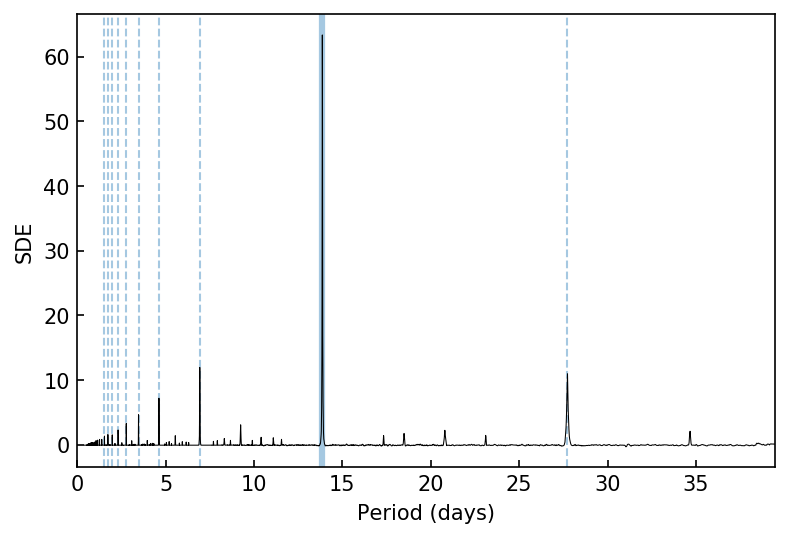

In [5]:
from matplotlib import rcParams; rcParams["figure.dpi"] = 150
plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(numpy.min(results.periods), numpy.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.xlim(0, max(results.periods));

This can be compared to the ``power_raw`` spectrum without the sliding median applies. This is very similar to the *BLS* power spectrum. The trend is visible.

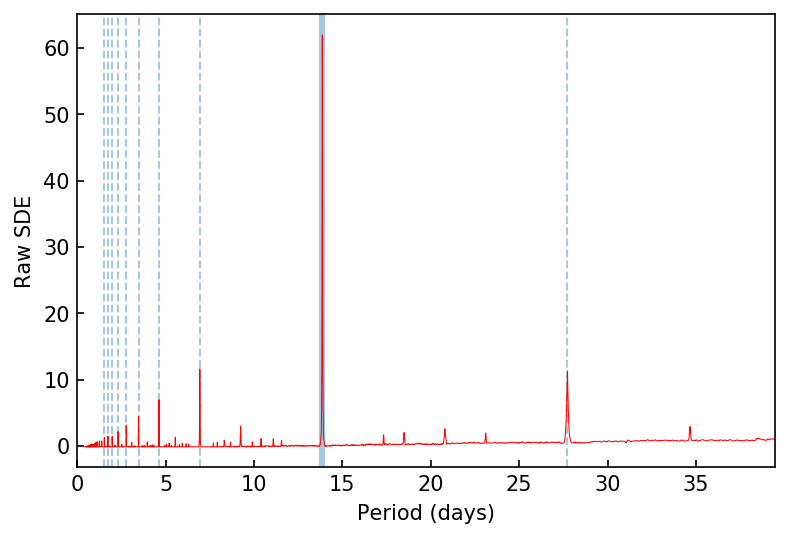

In [6]:
plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(numpy.min(results.periods), numpy.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'Raw SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power_raw, color='red', lw=0.5)
plt.xlim(0, max(results.periods));

The raw "SDE" spectrum is derived from the $\chi^2$ minima per period (over all phases, durations and depths). We can plot the $\chi^2$ spectrum, where the best period has the smallest value:

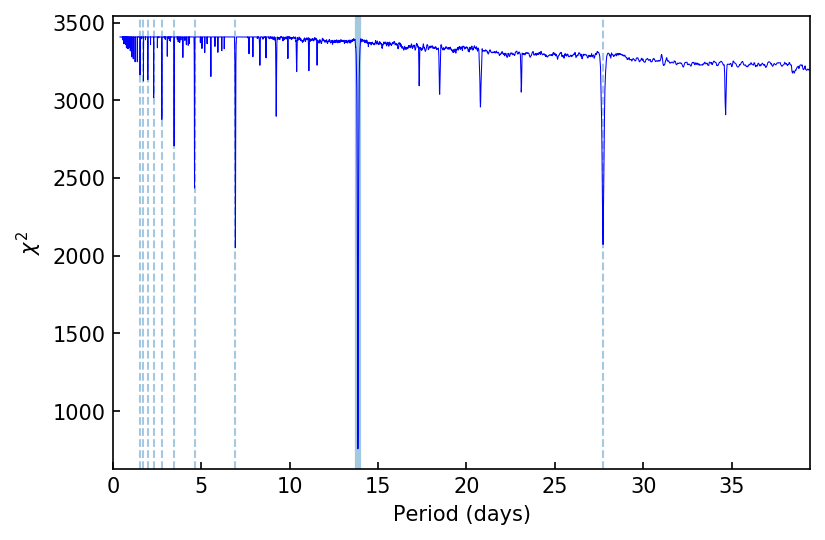

In [7]:
plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(numpy.min(results.periods), numpy.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'$\chi^2$')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.chi2, color='blue', lw=0.5)
plt.xlim(0, max(results.periods));

With $\sim4000$ data points and 4 degrees of freedom, we can calculate the reduced $\chi^2$. As expected, the noise floor is close to $\chi^2_{\rm red}\sim1$:

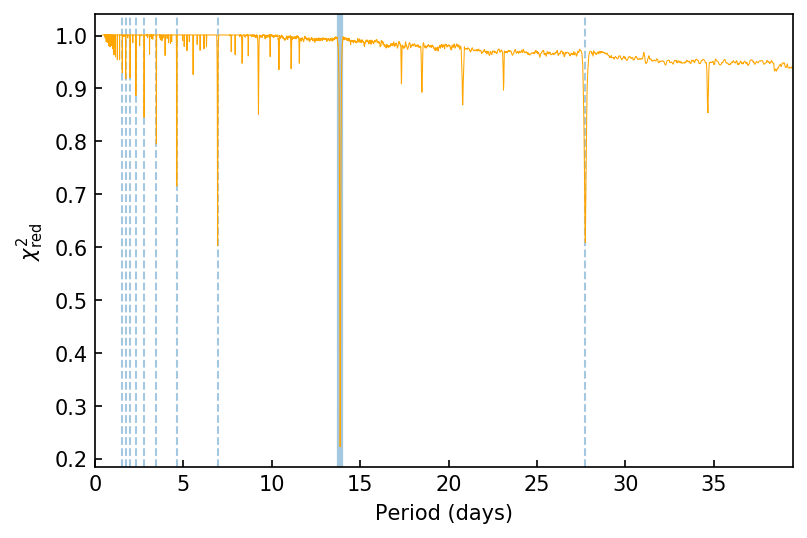

In [8]:
plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(numpy.min(results.periods), numpy.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'$\chi^2_{\rm red}$')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.chi2red, color='orange', lw=0.5)
plt.xlim(0, max(results.periods));

Lastly, a traditional way to examine the *BLS* results is the signal residue (SR), which TLS can closely reproduce. Its values are in the range [0,1]:

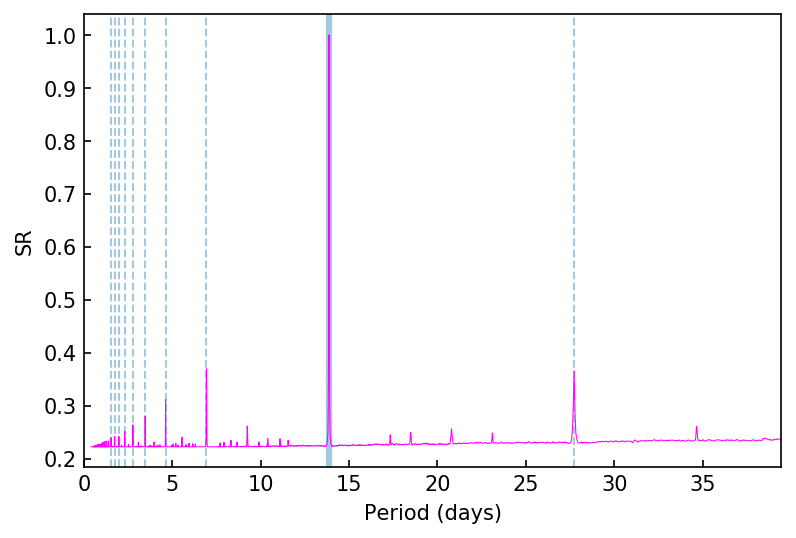

In [9]:
plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(numpy.min(results.periods), numpy.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SR')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.SR, color='magenta', lw=0.5)
plt.xlim(0, max(results.periods));